[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLO11 Object Detection on a Custom Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

YOLO11 builds on the advancements introduced in YOLOv9 and YOLOv10 earlier this year, incorporating improved architectural designs, enhanced feature extraction techniques, and optimized training methods.

YOLO11m achieves a higher mean mAP score on the COCO dataset while using 22% fewer parameters than YOLOv8m, making it computationally lighter without sacrificing performance.

YOLOv11 is available in 5 different sizes, ranging from `2.6M` to `56.9M` parameters, and capable of achieving from `39.5` to `54.7` mAP on the COCO dataset.

## Setup

### Configure API keys

To fine-tune YOLO11, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Dec  7 12:40:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.6/112.6 GB disk)


## Inference with model pre-trained on COCO dataset

### CLI

**NOTE:** CLI requires no customization or Python code. You can simply run all tasks from the terminal with the yolo command.

In [ ]:
!yolo task=detect mode=predict model=yolo11n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 5.35M/5.35M [00:00<00:00, 101MB/s]
Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs

100% 104k/104k [00:00<00:00, 72.9MB/s]
image 1/1 /content/dog.jpeg: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 60.1ms
Speed: 13.2ms preprocess, 60.1ms inference, 801.9ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


**NOTE:** Result annotated image got saved in `{HOME}/runs/detect/predict/`. Let's display it.

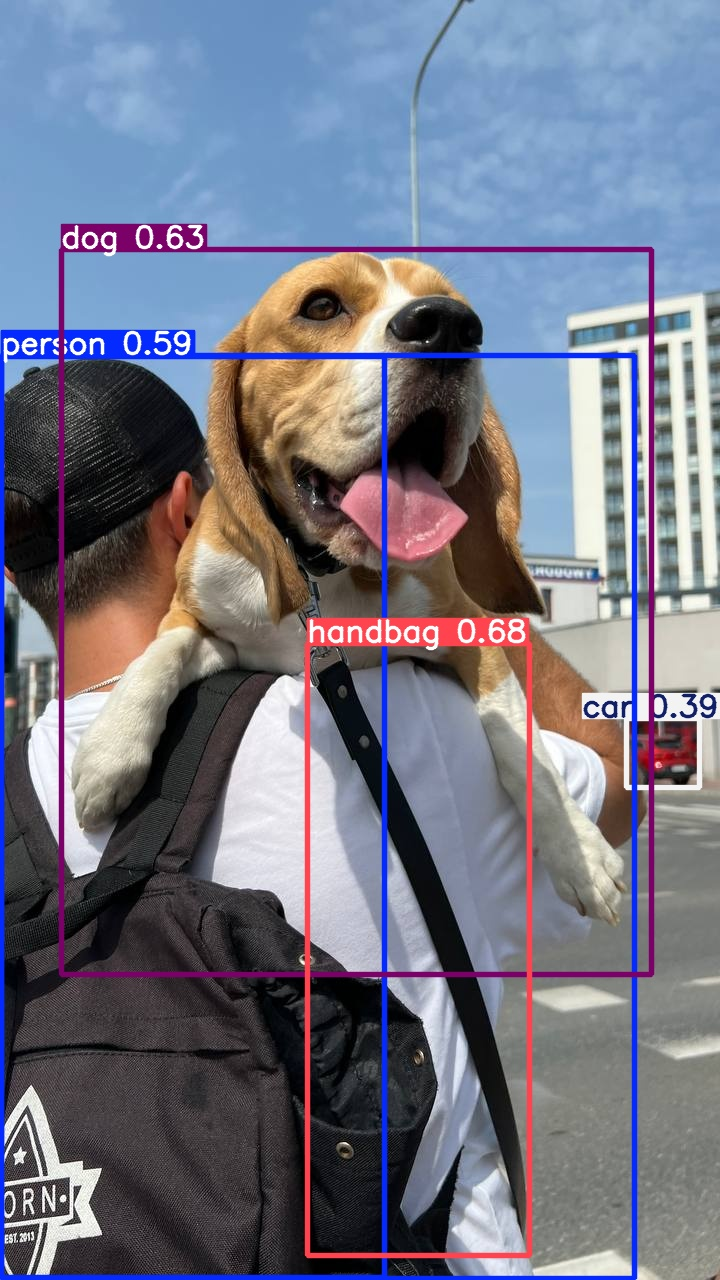

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpeg', width=600)

### SDK

**NOTE:** YOLO's Python interface allows for seamless integration into your Python projects, making it easy to load, run, and process the model's output.

In [ ]:
from ultralytics import YOLO
from PIL import Image
import requests

model = YOLO('yolo11n.pt')
image = Image.open(requests.get('https://media.roboflow.com/notebooks/examples/dog.jpeg', stream=True).raw)
result = model.predict(image, conf=0.25)[0]

100%|██████████| 5.35M/5.35M [00:00<00:00, 91.8MB/s]



0: 640x384 2 persons, 1 car, 1 dog, 1 handbag, 98.2ms
Speed: 23.9ms preprocess, 98.2ms inference, 834.1ms postprocess per image at shape (1, 3, 640, 384)


**NOTE:** The obtained `result` object stores information about the location, classes, and confidence levels of the detected objects.

In [ ]:
result.boxes.xyxy

tensor([[3.0705e+02, 6.4341e+02, 5.2919e+02, 1.2558e+03],
        [6.1400e+01, 2.4994e+02, 6.5165e+02, 9.7412e+02],
        [1.7803e+00, 3.5551e+02, 6.3404e+02, 1.2788e+03],
        [1.1933e+00, 3.5620e+02, 3.8455e+02, 1.2776e+03],
        [6.2615e+02, 7.1818e+02, 6.9975e+02, 7.8754e+02]], device='cuda:0')

In [ ]:
result.boxes.conf

tensor([0.6832, 0.6284, 0.5941, 0.3923, 0.3875], device='cuda:0')

In [ ]:
result.boxes.cls

tensor([26., 16.,  0.,  0.,  2.], device='cuda:0')

**NOTE:** YOLO11 can be easily integrated with `supervision` using the familiar `from_ultralytics` connector.

In [ ]:
import supervision as sv

detections = sv.Detections.from_ultralytics(result)

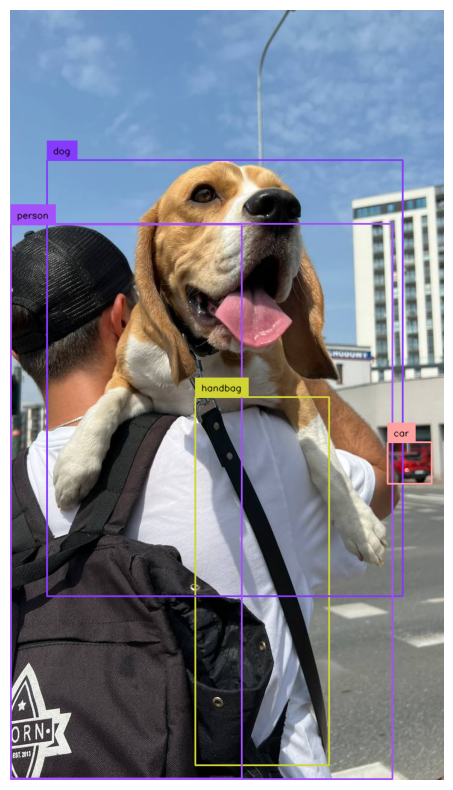

In [ ]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(annotated_image, size=(10, 10))

## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

# ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
# rf = Roboflow(api_key=ROBOFLOW_API_KEY)

# workspace = rf.workspace("liangdianzhong")
# project = workspace.project("-qvdww")
# version = project.version(3)
# dataset = version.download("yolov11")

rf = Roboflow(api_key="Oi6CO3h0iqqnTSrpeZPc")
project = rf.workspace("pest-research").project("mufeel")
version = project.version(8)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Mufeel-8 in yolov11:: 100%|██████████| 2498/2498 [00:00<00:00, 4755.66it/s]


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data=/content/datasets/Mufeel-8/data.yaml epochs=100 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 191MB/s]
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Mufeel-8/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, s

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

# !ls {HOME}/runs/detect/train2/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1733074292.5151fff97a98.2091.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	 val_batch2_pred.jpg
labels.jpg					    train_batch4950.jpg  weights
P_curve.png					    train_batch4951.jpg
PR_curve.png					    train_batch4952.jpg


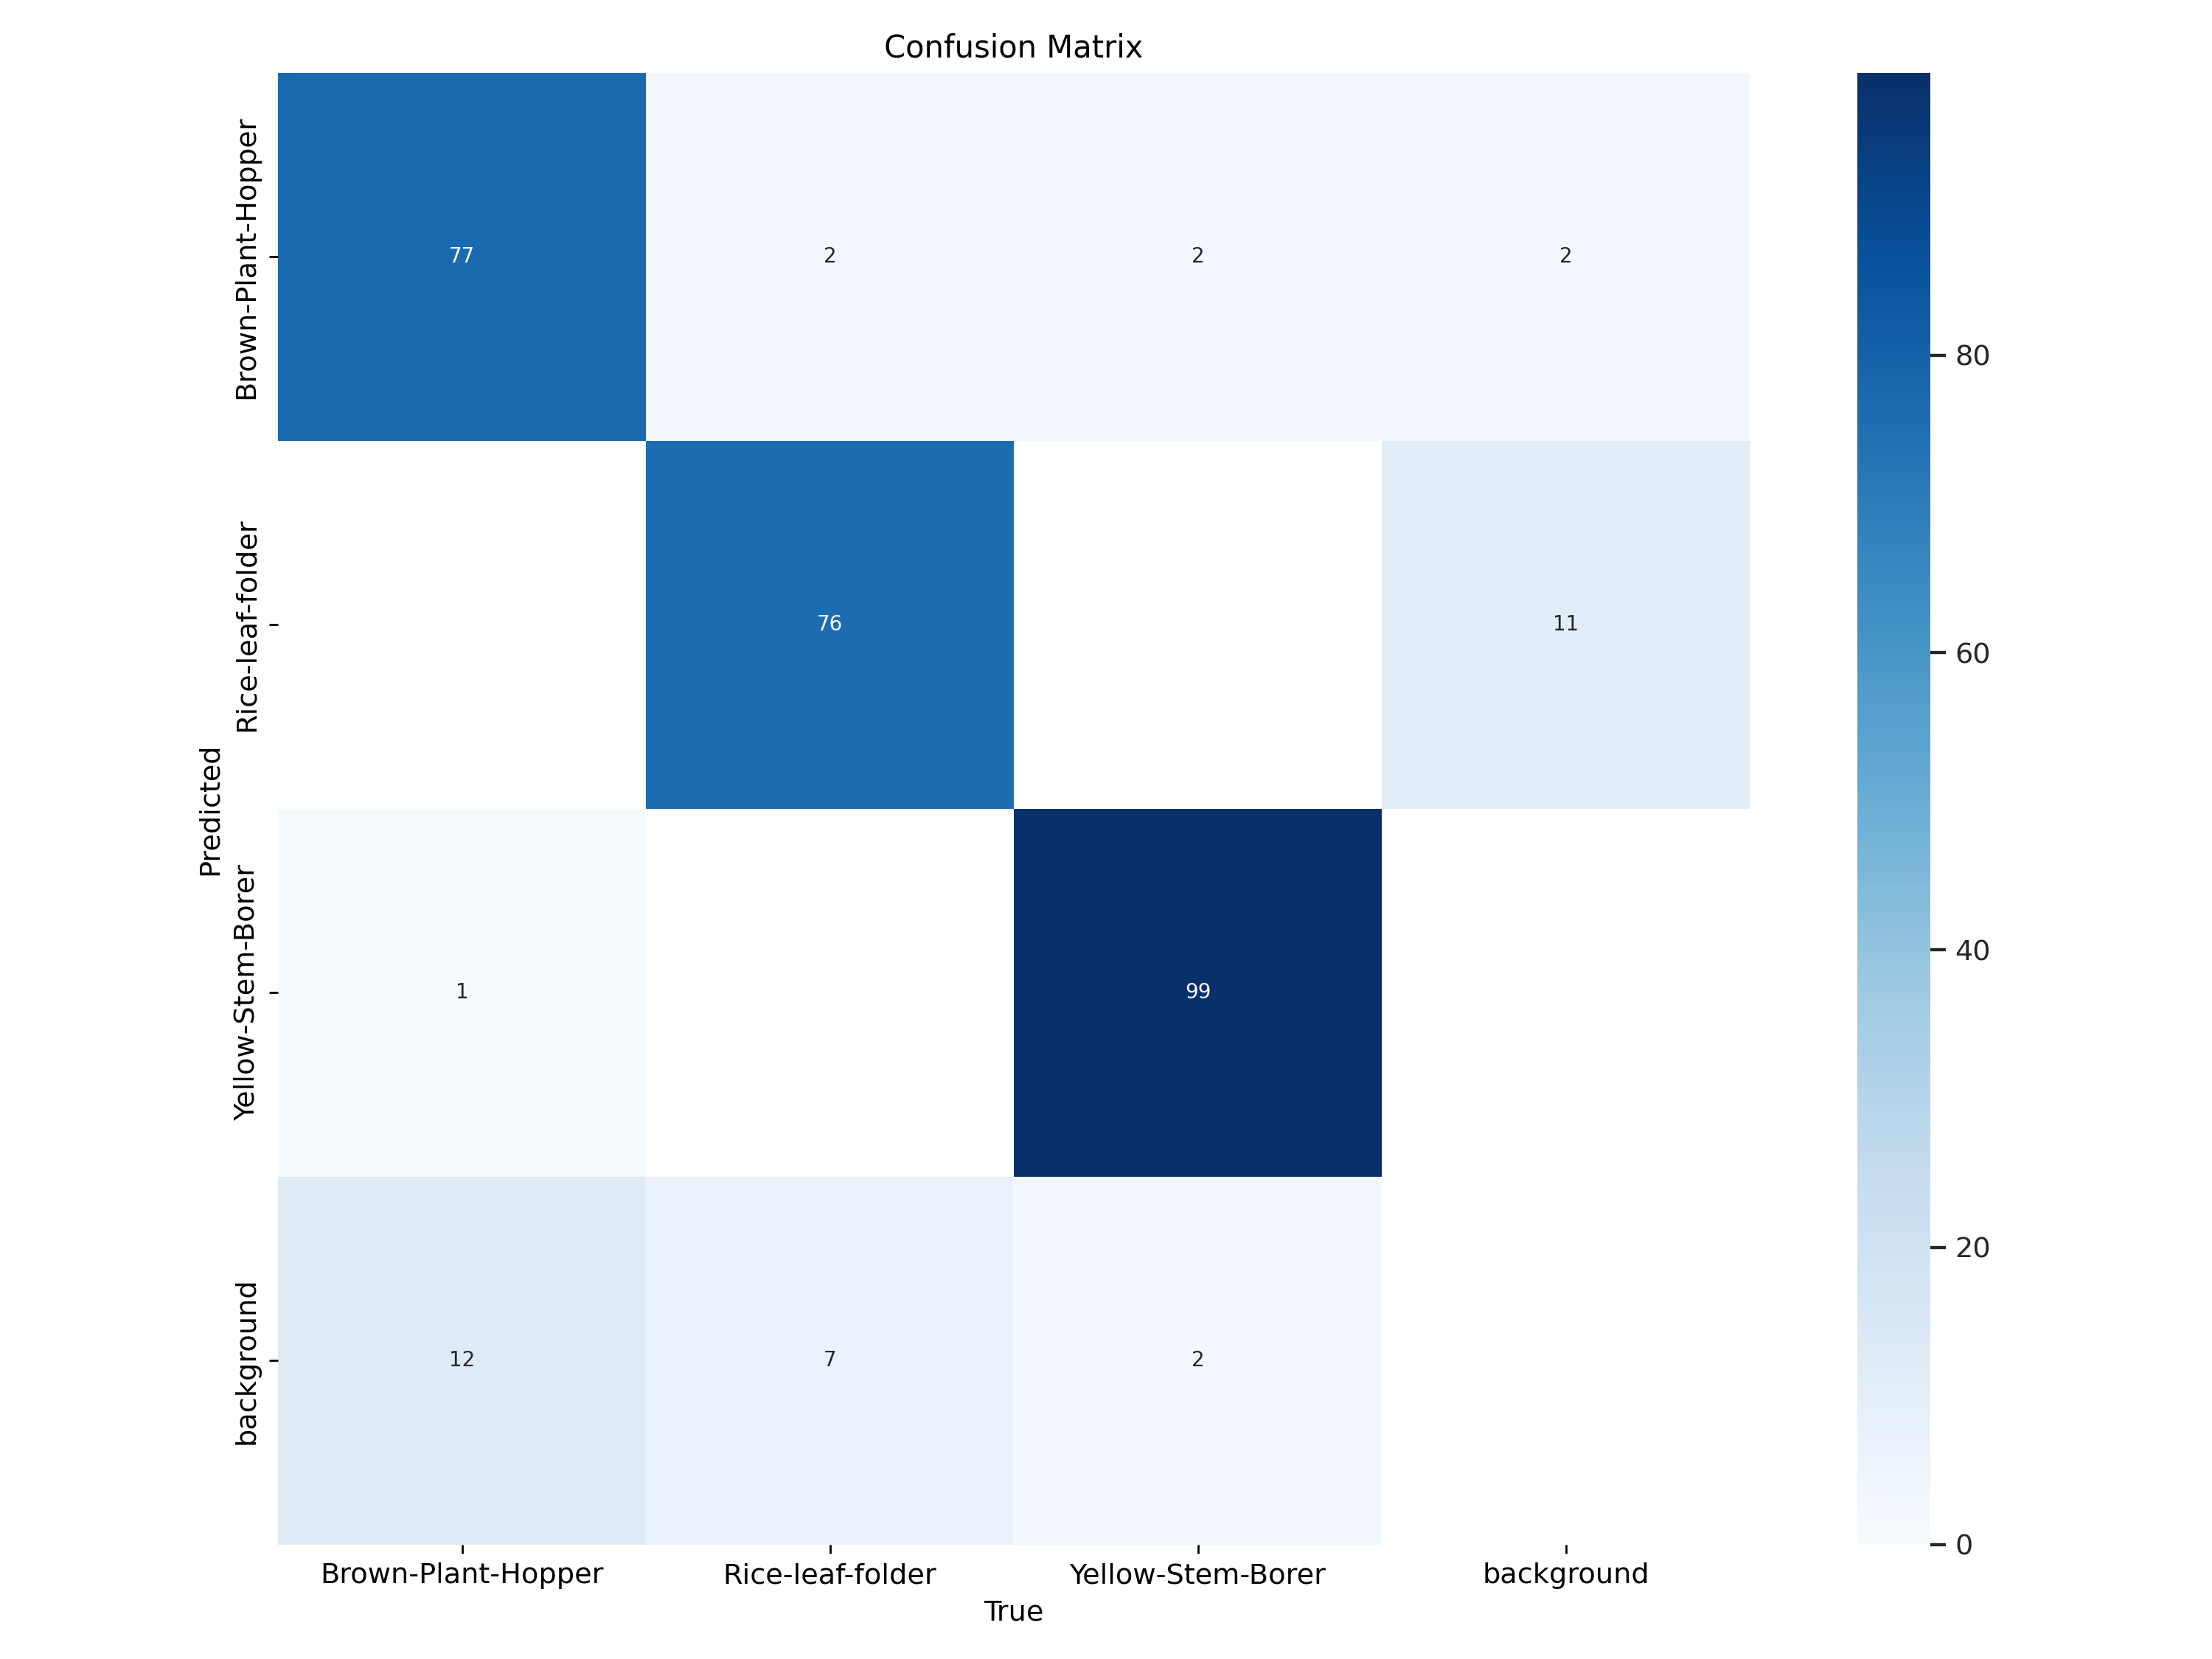

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

# IPyImage(filename=f'{HOME}/runs/detect/train2/confusion_matrix.png', width=600)

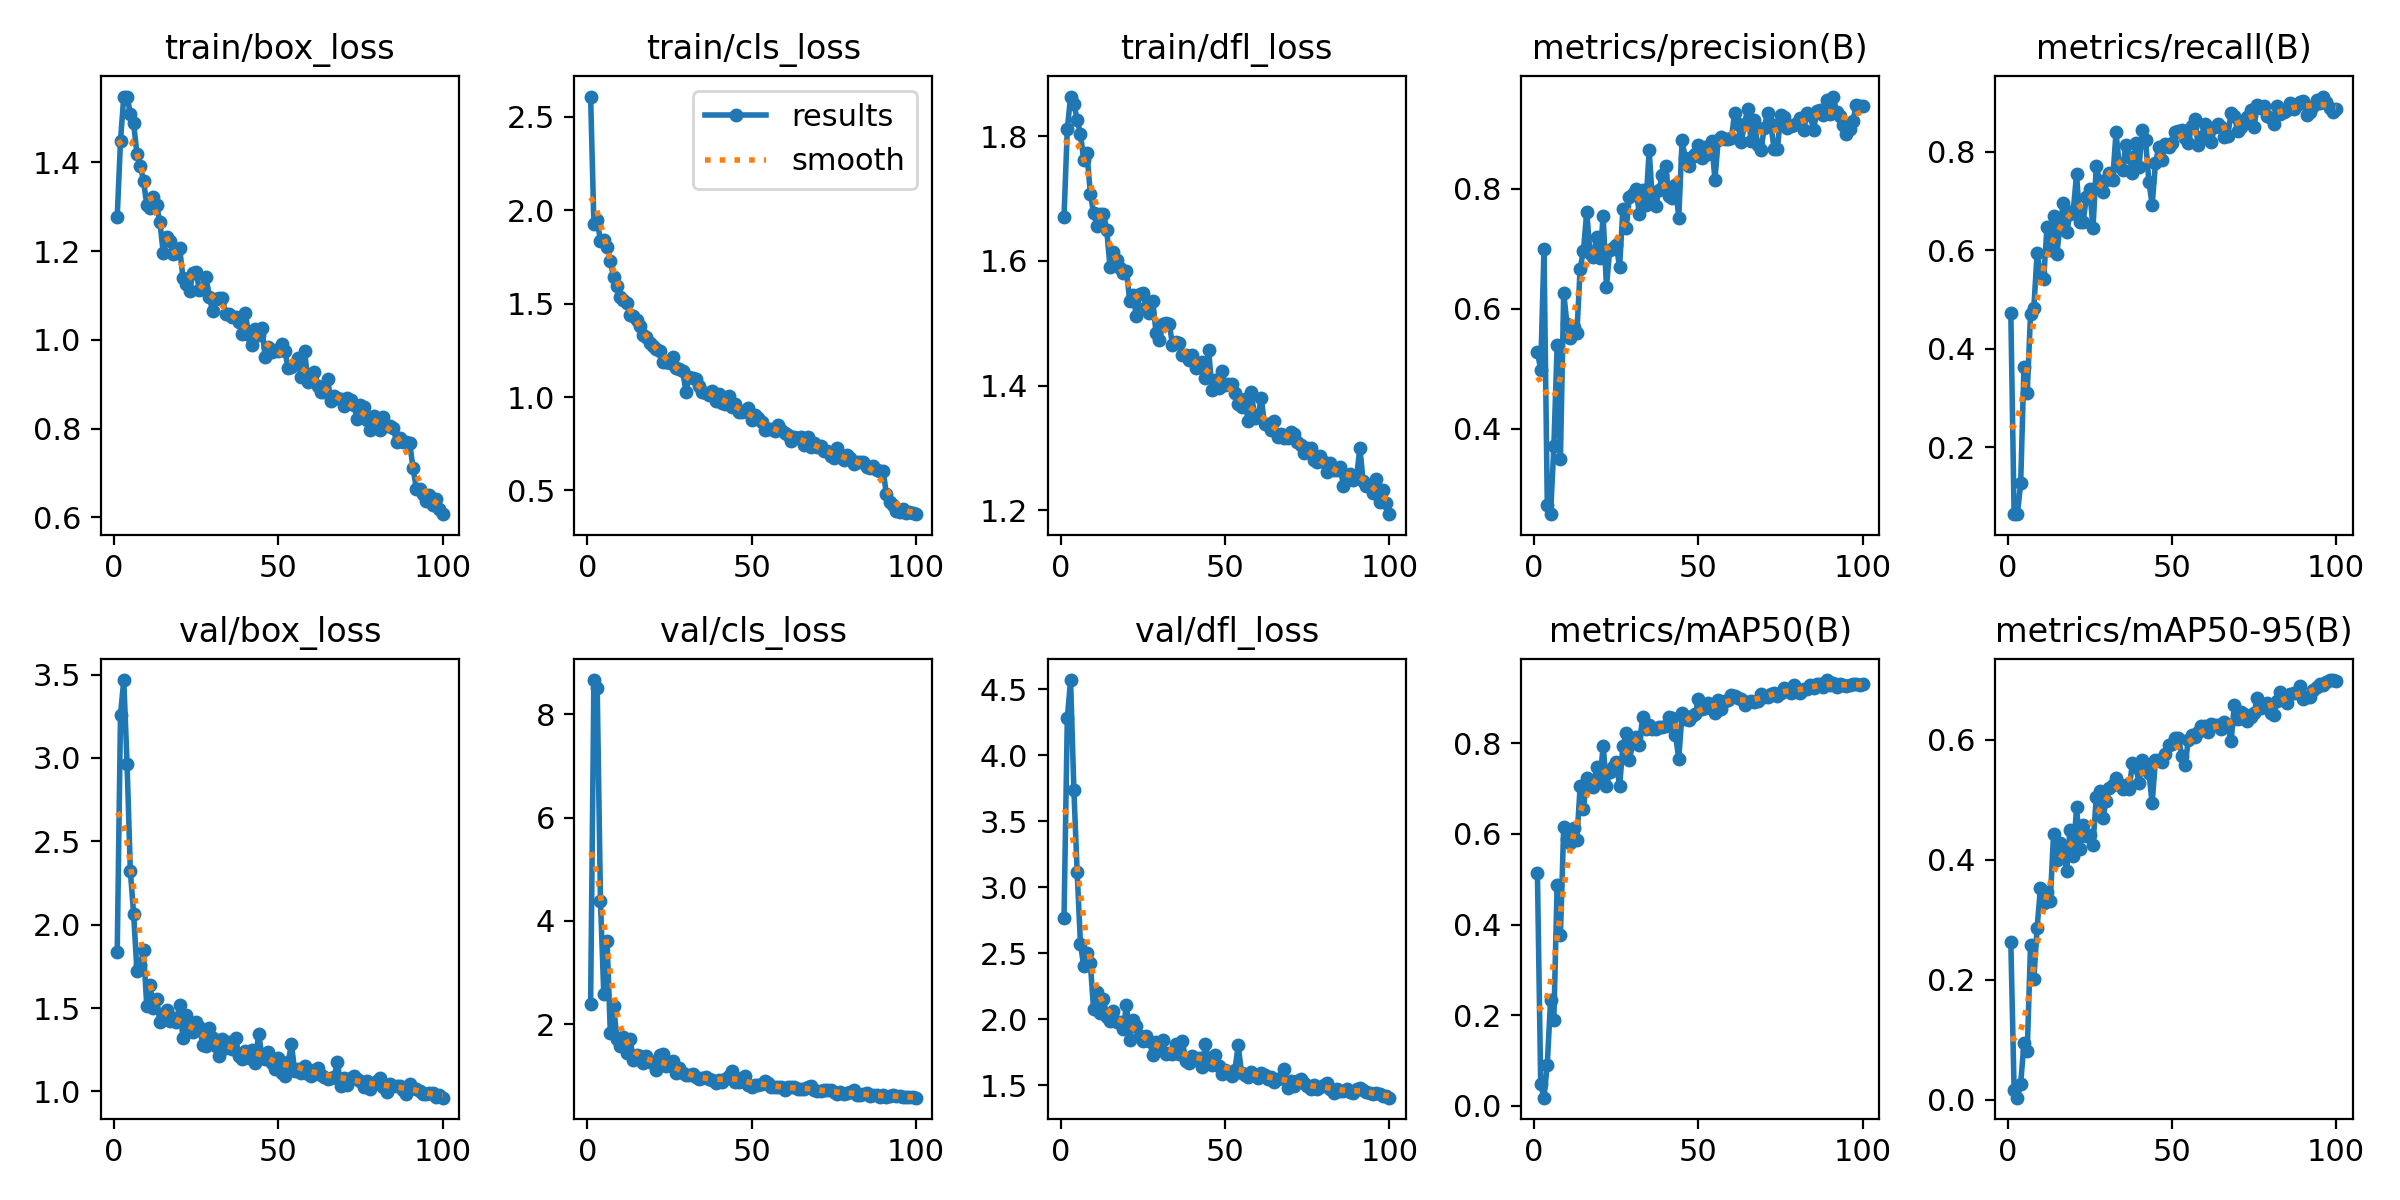

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

# IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

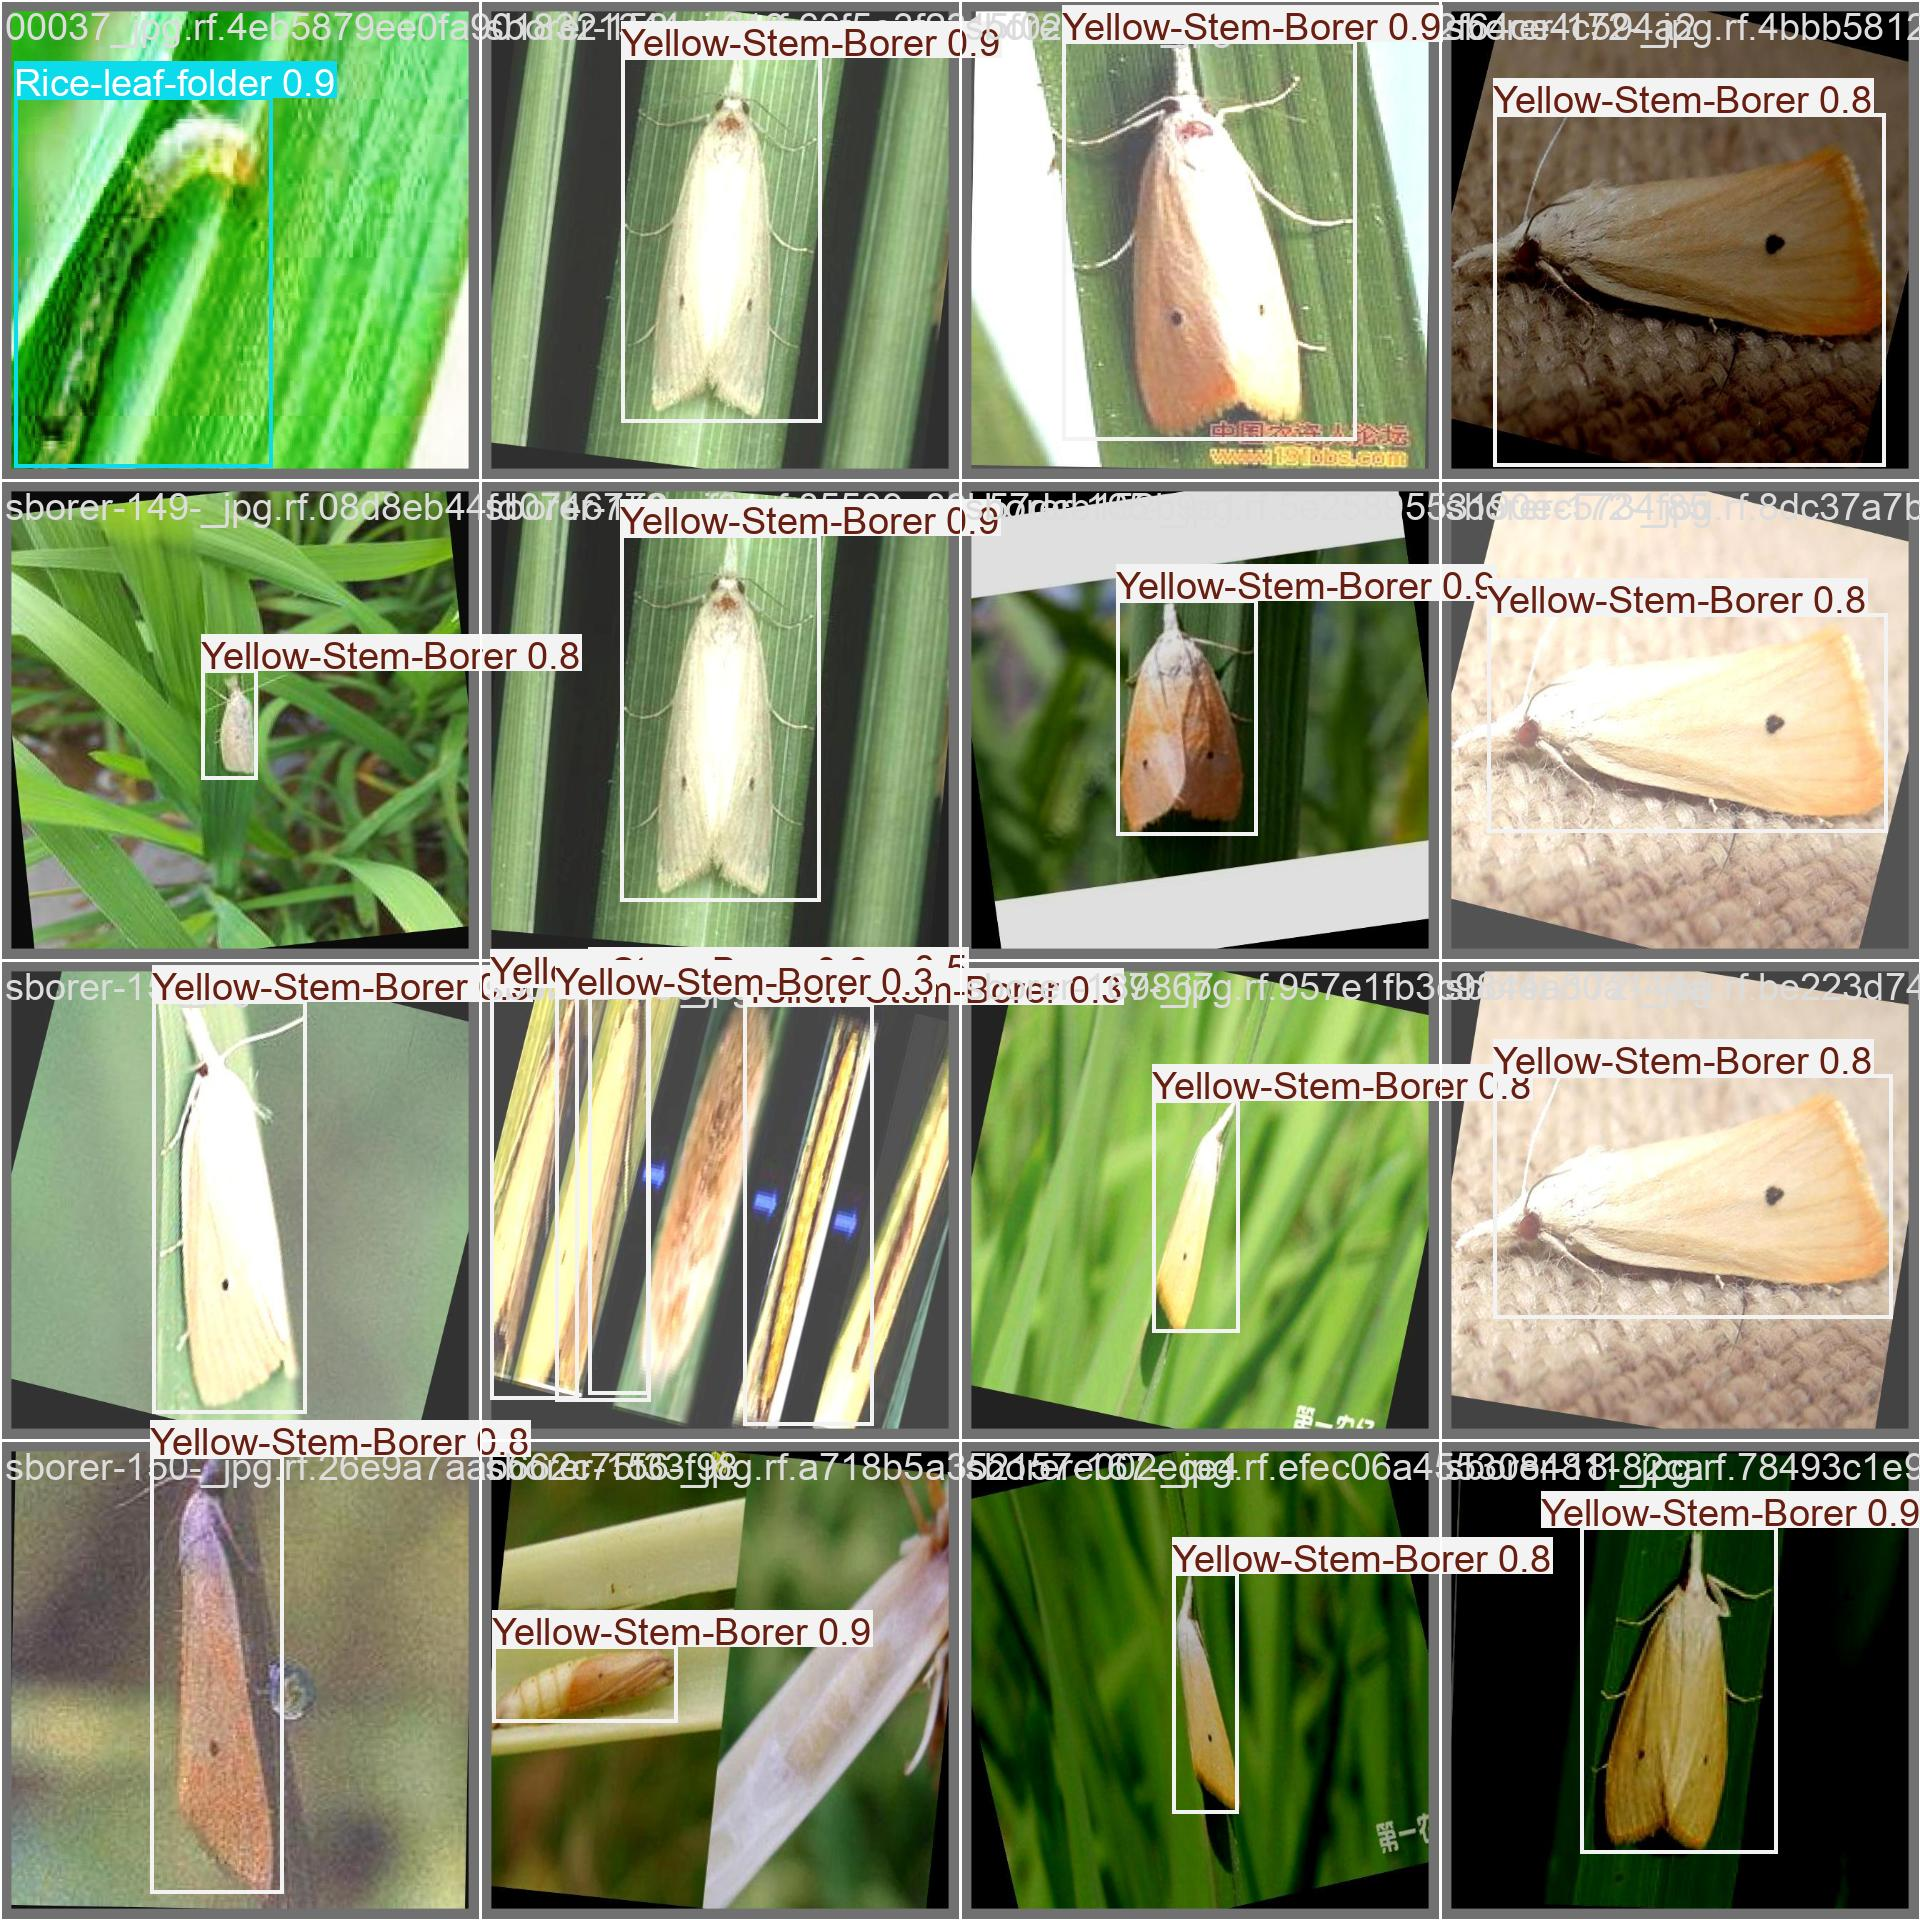

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

# IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data=/content/datasets/Mufeel-8/data.yaml

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Mufeel-8/valid/labels.cache... 247 images, 0 backgrounds, 0 corrupt: 100% 247/247 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 278. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 16/16 [00:04<00:00,  3.38it/s]
                   all        247        278       0.94      0.889       0.93      0.698
    Brown-Plant-Hopper         74         90      0.936      0.856      0.919       0.76
      Rice-leaf-folder         83         85        0.9      0.851      0.877      0.535
     Yellow-Stem-Borer         93       

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data=/content/datasets/Mufeel-8/data.yaml

Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/Mufeel-8/valid/labels.cache... 247 images, 0 backgrounds, 0 corrupt: 100% 247/247 [00:00<?, ?it/s]
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 1, len(boxes) = 278. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 16/16 [00:04<00:00,  3.32it/s]
                   all        247        278      0.944      0.874      0.918      0.673
    Brown-Plant-Hopper         74         90      0.929      0.873      0.893      0.721
      Rice-leaf-folder         83         85      0.919      0.788      0.872      0.523
     Yellow-Stem-Borer         93       

## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source=/content/datasets/Mufeel-8/test/images save=True

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/122 /content/datasets/Mufeel-8/test/images/00015_jpg.rf.521b6f4dc07bf9bfa9ada5e43f3ac272.jpg: 640x640 1 Rice-leaf-folder, 15.3ms
image 2/122 /content/datasets/Mufeel-8/test/images/00015_jpg.rf.585b6682f295a6dc23fadbf199a7c13a.jpg: 640x640 1 Rice-leaf-folder, 15.3ms
image 3/122 /content/datasets/Mufeel-8/test/images/00015_jpg.rf.c5fbe86cfbf9d71de6129c8905da667b.jpg: 640x640 1 Rice-leaf-folder, 15.2ms
image 4/122 /content/datasets/Mufeel-8/test/images/00027_jpg.rf.c3efa9deeb76a9895b1c3076870c2344.jpg: 640x640 1 Rice-leaf-folder, 15.2ms
image 5/122 /content/datasets/Mufeel-8/test/images/00049_jpg.rf.11cb3761560660a475b6eba90d679009.jpg: 640x640 2 Rice-leaf-folders, 15.2ms
image 6/122 /content/datasets/Mufeel-8/test/images/00058_jpg.rf.94abb28fbaf7a063730c61361b4f922c.jpg: 640x640 1 Rice-leaf-folder, 15.2ms
image 7/12

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source=/content/datasets/Mufeel-8/test/images save=True

Ultralytics 8.3.35 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/122 /content/datasets/Mufeel-8/test/images/00015_jpg.rf.521b6f4dc07bf9bfa9ada5e43f3ac272.jpg: 640x640 1 Rice-leaf-folder, 15.7ms
image 2/122 /content/datasets/Mufeel-8/test/images/00015_jpg.rf.585b6682f295a6dc23fadbf199a7c13a.jpg: 640x640 1 Rice-leaf-folder, 15.6ms
image 3/122 /content/datasets/Mufeel-8/test/images/00015_jpg.rf.c5fbe86cfbf9d71de6129c8905da667b.jpg: 640x640 2 Rice-leaf-folders, 15.6ms
image 4/122 /content/datasets/Mufeel-8/test/images/00027_jpg.rf.c3efa9deeb76a9895b1c3076870c2344.jpg: 640x640 1 Brown-Plant-Hopper, 15.6ms
image 5/122 /content/datasets/Mufeel-8/test/images/00049_jpg.rf.11cb3761560660a475b6eba90d679009.jpg: 640x640 1 Rice-leaf-folder, 15.6ms
image 6/122 /content/datasets/Mufeel-8/test/images/00058_jpg.rf.94abb28fbaf7a063730c61361b4f922c.jpg: 640x640 1 Rice-leaf-folder, 15.6ms
image 7/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/YOLOv11ResultsV2
!cp -r runs/detect/train /content/drive/MyDrive/YOLOv11ResultsV2/


Mounted at /content/drive


In [ ]:
!cp -r runs/detect /content/drive/MyDrive/YOLOv11ResultsV2/

In [ ]:
!python export.py --weights runs/detect/train2/weights/best.pt --include tflite

python3: can't open file '/content/export.py': [Errno 2] No such file or directory


In [ ]:
!yolo export model=runs/detect/train/weights/best.pt format=tflite


Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 7, 8400) (18.3 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime'] not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

**NOTE:** Let's take a look at few results.

In [ ]:
import cv2
import os

# Define source and destination folders
source_folder = "/content/drive/MyDrive/demo"
destination_folder = "/content/drive/MyDrive/resize"

# Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Resize dimensions (width, height)
resize_width = 640
resize_height = 640

# Process all images in the source folder
for image_name in os.listdir(source_folder):
    image_path = os.path.join(source_folder, image_name)
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Read the image
        image = cv2.imread(image_path)

        # Resize the image
        resized_image = cv2.resize(image, (resize_width, resize_height))

        # Save the resized image in the destination folder
        output_path = os.path.join(destination_folder, image_name)
        cv2.imwrite(output_path, resized_image)

print("Resizing completed. Resized images are saved in:", destination_folder)


Resizing completed. Resized images are saved in: /content/drive/MyDrive/resize


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


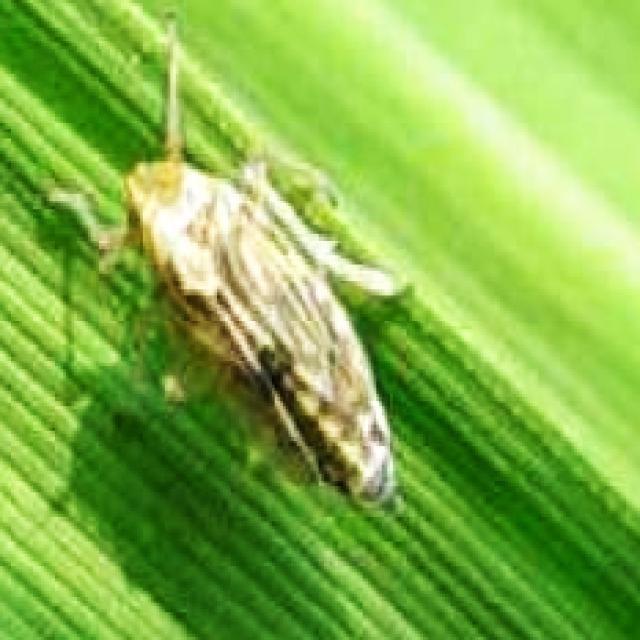

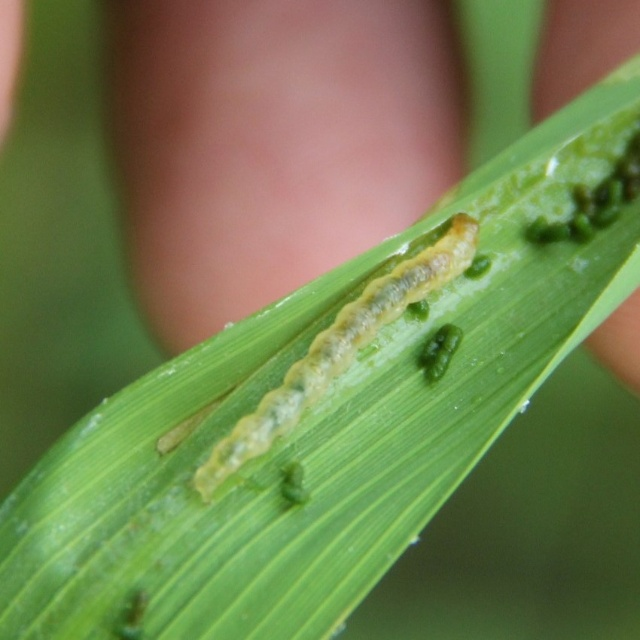

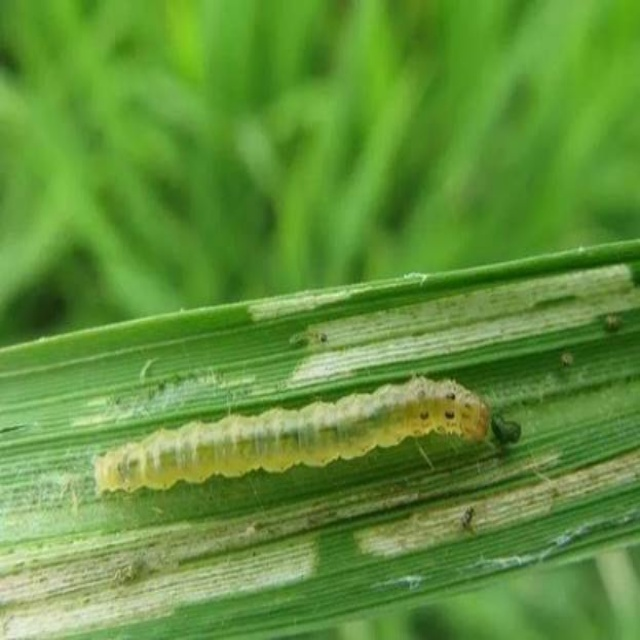

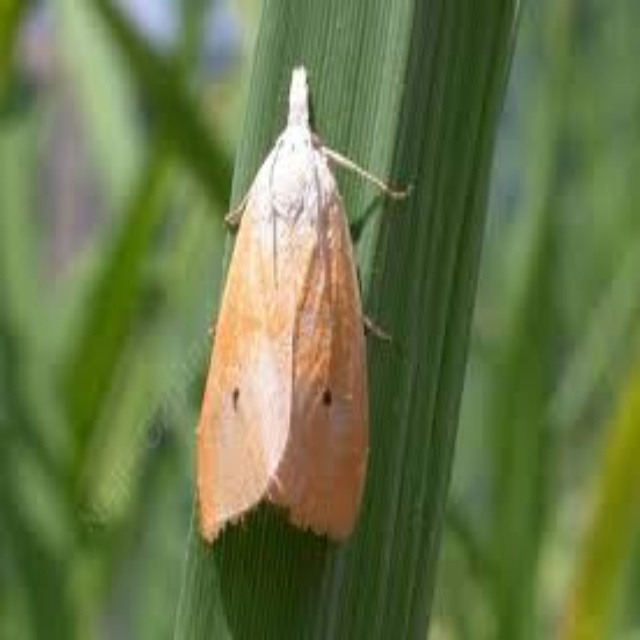

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/drive/MyDrive/resize*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:6]:
    display(IPyImage(filename=img, width=400, height=400))
    print("\n")

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/YOLOv11ResultsV2/train/weights/best.pt conf=0.25 source=/content/drive/MyDrive/resize save=True

Ultralytics 8.3.44 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11s summary (fused): 238 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/4 /content/drive/MyDrive/resize/05020.jpg: 640x640 1 Brown-Plant-Hopper, 15.7ms
image 2/4 /content/drive/MyDrive/resize/492faa19-fd75-4142-98fc-03897e82a580.jpg: 640x640 1 Rice-leaf-folder, 16.2ms
image 3/4 /content/drive/MyDrive/resize/demo.jpg: 640x640 1 Rice-leaf-folder, 15.7ms
image 4/4 /content/drive/MyDrive/resize/images.jpg: 640x640 1 Yellow-Stem-Borer, 15.6ms
Speed: 3.5ms preprocess, 15.8ms inference, 201.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


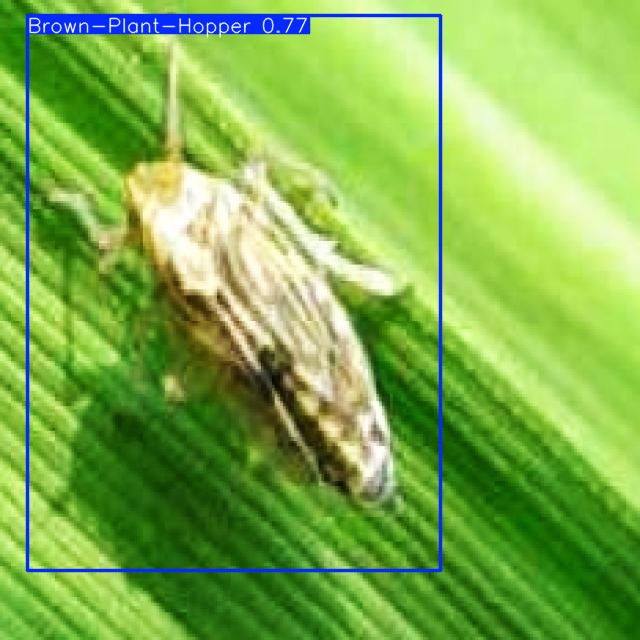

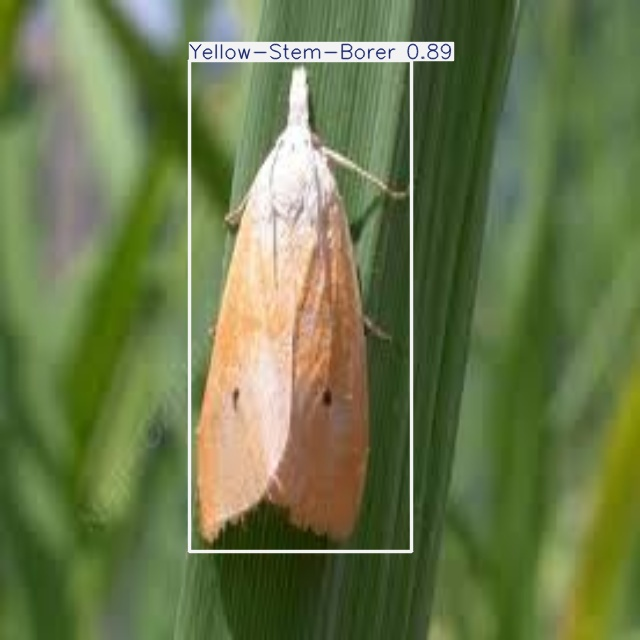

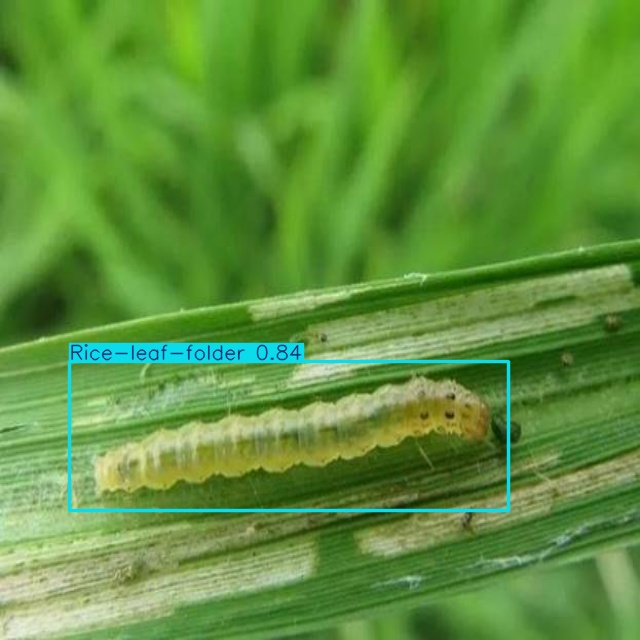

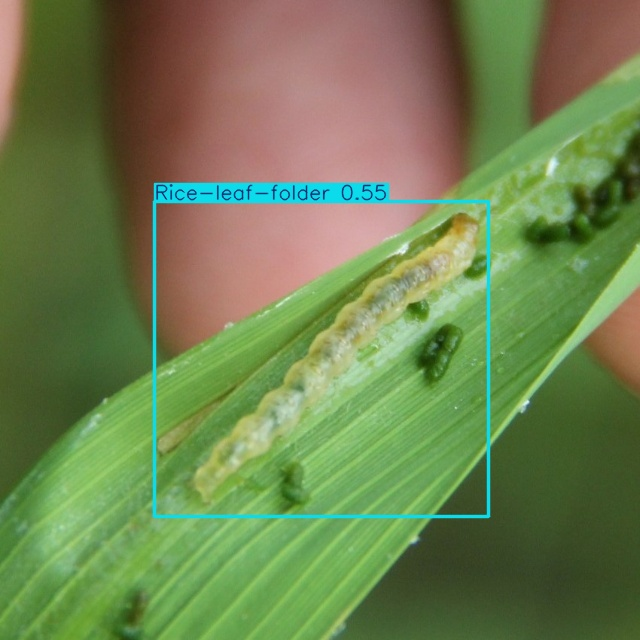

In [ ]:
latest_folder = max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:6]:
    display(IPyImage(filename=img, width=400, height=400))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [ ]:
project.version('100').deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

NameError: name 'project' is not defined

In [ ]:
!pip install inference

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.5/880.5 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.9/891.9 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.7/774.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.